# 情感分析（隐含特征词、候选观点词）

In [59]:
#这个库是支持导入其他ipynb
import Ipynb_importer
import pickle
from collections import defaultdict
#读入特征词观点词字典
with open('F:/data6/new_new_fea_to_opinion_dict.pkl', mode='rb') as f:
    fea_to_opinion_dict = pickle.load(f)
with open('F:/data6/new_new_opinion_to_fea_dict.pkl', mode='rb') as f:
    opinion_to_fea_dict = pickle.load(f)
###print(fea_to_opinion_dict.keys())

candidate_opinion_list = [] #候选观点词列表
#读入选观点词
with open('F:/data/candidate_opinion.txt', 'r') as f:
    for w in f.readlines():
        w = w.strip().replace('\n', '')
        candidate_opinion_list.append(w)
###print(candidate_opinion_list)
###print(fea_to_opinion_dict)

#从特征词观点词字典中我们观察，以及结合现实实际，发现单个字的特征词多数为动词，无法体现出商品的特征，所以删除
new_fea_to_opinion_dict = defaultdict(list)###############特征词观点词字典####################
for key in fea_to_opinion_dict:
    if len(fea_to_opinion_dict[key]) != 1 and len(key) != 1:
        new_fea_to_opinion_dict[key] = fea_to_opinion_dict[key]
###print(new_fea_to_opinion_dict.keys())

In [60]:
#导入text_process里面有读取文件和分词等操作
import text_process as tp

In [61]:
import numpy as np
from collections import defaultdict 
from collections import Counter

## 读入情感词典（pos，neg）读入程度副词词典

In [62]:
#情感词典
posdict = tp.read_lines(r'C:\Users\Administrator\Desktop\motion\Sentiment_dict\emotion_dict\pos_all_dict.txt')
negdict = tp.read_lines(r'C:\Users\Administrator\Desktop\motion\Sentiment_dict\emotion_dict\neg_all_dict.txt')
#程度副词词典
mostdict = tp.read_lines(r'C:/Users/Administrator/Desktop/motion/Sentiment_dict/degree_dict/most.txt')
verydict = tp.read_lines(r'C:/Users/Administrator/Desktop/motion/Sentiment_dict/degree_dict/very.txt')
moredict = tp.read_lines(r'C:/Users/Administrator/Desktop/motion/Sentiment_dict/degree_dict/more.txt')
ishdict = tp.read_lines(r'C:/Users/Administrator/Desktop/motion/Sentiment_dict/degree_dict/ish.txt')
insufficientdict = tp.read_lines(r'C:/Users/Administrator/Desktop/motion/Sentiment_dict/degree_dict/insufficiently.txt')
inversedict = tp.read_lines(r'C:/Users/Administrator/Desktop/motion/Sentiment_dict/degree_dict/inverse.txt')


## 程度副词计分函数，包含5种程度副词和1种否定词

In [63]:
#程度副词处理
#参数两个，词和分数
#返回分数，和是否有否定副词
def match(word, sentiment_value):
    flag = 0
    if word in mostdict:
        sentiment_value *= 2.0
    elif word in verydict:
        sentiment_value *= 1.75
    elif word in moredict:
        sentiment_value *= 1.5
    elif word in ishdict:
        sentiment_value *= 1.2
    elif word in insufficientdict:
        sentiment_value *= 0.5
    elif word in inversedict:
        #print "inversedict", word
        sentiment_value *= -1
        flag = 1
    return sentiment_value, flag

## 针对每个分句进行情感分析计算得分

In [64]:
def analyze(seg_sent):
    poscount = 0
    negcount = 0
    i = 0
    s = 0
    for word in seg_sent:
        if word in posdict:
            poscount += 1
            for w in seg_sent[s:i]:
                poscount, flag = match(w, poscount)
            s = i + 1

        elif word in negdict:
            negcount += 1
            for w in seg_sent[s:i]:
                negcount, flag = match(w, negcount)
            s = i + 1

        elif word == '!' or word =='！':
            for w in seg_sent[::-1]:
                if w in posdict:
                    poscount += 2
                elif w in negdict:
                    negcount += 2

        i += 1
    #按理说一个分句中应该只有一个观点词，但是为了准确还是看看有没有多个观点词出现的情况。
    #sss为这个分句的分数
    sss = poscount - negcount
    return sss

## 获得特征词的聚类结果

In [65]:
#获取聚类的结果
#参数为特征词
#返回特征词的数字标签
def Kdict(word):
    fea_label = []#聚类的数字标签列表
    fea_words_list = []#聚类的特征词列表
    with open('F:/data/cluster_label.txt', mode='r',encoding='UTF-8') as f:
        for w in f.readlines():
            w = w.strip().replace('\n', '')
            fea_label.append(w)
    with open('F:/data/cluster_word_list.txt', mode='r', encoding='UTF-8') as f:
        for w in f.readlines():
            w = w.strip().replace('\n', '')
            fea_words_list.append(w)
    
    fea_label[0] = fea_label[0].replace('\ufeff','')
    fea_words_list[0] = fea_words_list[0].replace('\ufeff', '')
    #print(fea_words_list)
    
    id = fea_words_list.index(word)
    lable = fea_label[id]
    return lable,fea_label,fea_words_list

## 对单个评论进行情感分析包含推测隐含特征

In [79]:
def single_review_sentiment_score(weibo_sent):
    single_review_senti_score = [] #评论的得分
    single_review_senti_table = [] #评论的标签
    S = []
    cuted_review = tp.cut_sentence(weibo_sent) #进行分句，按照逗号分句
    tabledict = defaultdict(float)
    ii = 0
    flag3 = 0
    for sent in cuted_review:#对分句中每个进行分析
        ii += 1
        print('i',ii)
        seg_sent = tp.segmentation(sent) #分词后的分句
        seg_sent = tp.del_stopwords(seg_sent) #去除停用词后的分句
        i = 0
        s = 0
        poscount = 0 #积极得分
        negcount = 0 #消极得分 
        flag1 = 0
        flag2 = 0
        table_to_opi_list = []
        table = ''
        opi = ''
        #词在特征词中
        for word in seg_sent:
            for w in new_fea_to_opinion_dict.keys():
                #只会有一个特征词
                if word == w:
                    table = w  #记录下这个特征词
                    flag1 = 1 # 第一种情况，分句中有特征词，flag1 = 1
        #没有特征词只有观点词
        if flag1 != 1:            
            for word in seg_sent:
                for w in opinion_to_fea_dict.keys():
                    if word == w:
                        if word in posdict or word in negdict:
                            flag2 = 1 # 第二种情况，分句中没有特征词只有观点词并且观点词是情感字典中的词，flag2 = 1
                            opi = word
        #分句中有特征词
        if flag1:
            print('有特征词')
            #对每个分词后去除停用词后的分句
            for word in seg_sent:
                print(word)
                flag_inver = 0 #是否有否定副词
                
                if word in posdict:#如果有一个词在积极词典中
                    poscount += 1 #积极分数加一
                    for w in seg_sent[s:i]:
                        poscount, flag_inver = match(w, poscount) #分析它的副词计算得分
                    s = i + 1 #情感词的位置

                elif word in negdict:#如果有一个词在消极词典中
                    negcount += 1
                    for w in seg_sent[s:i]:
                        negcount, flag_inver = match(w, negcount)
                    s = i + 1

                elif word in candidate_opinion_list:#如果有一个词在候选观点词中
                    print('到我了')
                    poscount += 1   #假设候选观点词为积极的
                    for w in seg_sent[s:i]:
                        poscount, flag_inver = match(w, poscount)
                    s = i + 1
                    
                    #第三种情况，分句中有特征词，观点词为候选观点词 flag3 = 1
                    flag3 = 1
                    if flag_inver == 0: # 如果没有否定副词，将词对分数记为正
                        table_to_opi_list.append((table,word,poscount))
                    else:              # 如果有否定副词，将词对分数记为负
                        table_to_opi_list.append((table, word, -poscount))
                      
                elif word == '!' or word =='！': # 如果有感叹号，加2分
                    for w in seg_sent[::-1]:
                        if w in posdict:
                            poscount += 2
                        elif w in negdict:
                            negcount += 2

                i += 1
                
        #print(poscount, negcount)
            sss = poscount - negcount
            tabledict[table] += sss   #分局中 标签对应的得分
            
        #词不在特征词中，且观点词是情感字典中的词，那么预测特征词
        elif flag2:
            fea_list = opinion_to_fea_dict[opi]  #获得这个观点词对应的所有特征词
            dic = Counter(fea_list) #对列表元素计数
            print(dic)  
            a = sorted(dic, key=dic.__getitem__) #从小到大排序
            a.reverse() #倒序后的列表
            print(a)
            overlist = []  #隐含特征词列表
            for w in a:   #如果观点词对应的某个特征词占他全部观点词的50%，则推测这个观点词的隐含特征词。
                if dic[w]/len(fea_list) >= 0.5:
                    overlist.append(w)
            i = 0
            if overlist:
                a, fea_label, fea_word_list = Kdict(overlist[0]) #这个特征词的剧烈标签
                for w in overlist:#观点词对应的所有隐含特征词如果是一类则第一个特征词有效
                    b, bb, bbb = Kdict(w)
                    if b == a:
                        i += 1
                    
                    else:
                        print('不合适，无法推测隐含特征')
                        break
            else:
                print('无法推测出特征')
                    
            if i != 0 and i == len(overlist):#如果没有特征词
                print('推测出隐含特征', overlist[0])
                table = overlist[0]
                tabledict[table] += analyze(seg_sent)
            
                
            
        

        single_review_senti_table.append(table) #添加标签

    the_whole_score = 0 #评论的分数
    candidate_opinion_to_score_dict = defaultdict(int) #隐含观点词对应的分数
    yes_num = 0
    no_num = 0
    fea_to_realScore = []
    #处理分句中有特征词，观点词为候选观点词的情况
    if flag3:
        print('看啊看啊'+ str(weibo_sent))
        single_review_senti_score111 = []
        for sent111 in cuted_review: #对每个分句
            seg_sent111 = tp.segmentation(sent111) #分词
            seg_sent111 = tp.del_stopwords(seg_sent111) #停用词处理
            i111 = 0
            s111 = 0
            poscount111 = 0
            negcount111 = 0
            # 和原始的情感分析代码一样，计算句子的总分
            for word in seg_sent111:
                flag_inver = 0
                if word in posdict:
                    poscount += 1
                    for w in seg_sent[s:i]:
                        poscount, flag_inver = match(w, poscount)
                    s = i + 1

                elif word in negdict:
                    negcount += 1
                    for w in seg_sent[s:i]:
                        negcount, flag_inver = match(w, negcount)
                    s = i + 1


                elif word == '!' or word =='！':
                    for w in seg_sent[::-1]:
                        if w in posdict:
                            poscount += 2
                        elif w in negdict:
                            negcount += 2

                i += 1
        single_review_senti_score111.append((poscount, negcount))
        pos_result, neg_result = 0, 0   # 分别记录积极情感总得分和消极情感总得分
        for res1, res2 in single_review_senti_score111:  # 每个分句循环累加
            pos_result += res1
            neg_result += res2
            print('积极结果和消极结果',pos_result, neg_result)
        the_whole_score = pos_result - neg_result   # 该条微博情感的最终得分
#         for key in tabledict:
#             the_whole_score += tabledict[key]
        print(the_whole_score)
    
    #因为是假设候选观点词为褒义词，所以入国整句为褒义词那么这个假设成立，如果为贬义词，那么假设不成立，为贬义词
        for w in table_to_opi_list:
            fea = w[0]
            opi = w[1]
            real_score = w[2]
            print(fea,opi,real_score)
            score = tabledict[fea]
            if the_whole_score > 0:
                if score > 0:
                    print('right，褒贬符合语境，说明你是褒义词啊')
                    yes_num += 1
                if score <= 0:
                    no_num += 1
                    print('false，褒贬不符合语境，说明你是贬义词啊')
                    real_score = -w[2]
            if the_whole_score < 0:
                if score >= 0:
                    print('false，褒贬不符合语境')
                    no_num += 1
                    real_score = -w[2]
                if score < 0:
                    yes_num += 1
                    print('right，褒贬符合语境')
            fea_to_realScore.append((fea, opi, real_score))
       
        
            

    print('特征词对分数',fea_to_realScore)
    return  single_review_senti_table, tabledict, fea_to_realScore#返回标签，

## 测试情感分析

In [78]:
# weibo_sent = '这东西不好，非常不好，物流大'
# table,dict1, a= single_review_sentiment_score(weibo_sent)
# #print(table)
# print(dict1)
# #print(fea_candidateOpi_real_score)

i 1
有特征词
东西
不好
，
i 2
Counter({'质量': 1})
['质量']
推测出隐含特征 质量
i 3
有特征词
物流
大
到我了
看啊看啊这东西不好，非常不好，物流大
积极结果和消极结果 1 2
-1
物流 大 1
false，褒贬不符合语境
特征词对分数 [('物流', '大', -1)]
defaultdict(<class 'float'>, {'东西': -1.0, '质量': -1.75, '物流': 1.0})


## 执行分析函数，并记录候选特征词观点词词对分数

In [80]:
neg_to_num_dict = defaultdict(int)  #特征词为负的个数
fea_to_num_dict = defaultdict(int) #特征词出现的次数
def run_score():
    fp_test = open('F:/data/comment_clean.txt',encoding='UTF-8')
    contents = []
    for content in fp_test.readlines():
        content = content.strip()
        contents.append(content)
    fp_test.close()  
    results = []
    fea_to_allscore_dict = defaultdict(float)
    
    fea_candadateOpi_score_list = []
    for content in contents:
        lable, fea_to_score_dict, a = single_review_sentiment_score(content)
        fea_candadateOpi_score_list += a
        results.append((fea_to_score_dict, content))
        for w in fea_to_score_dict.keys():
            fea_to_allscore_dict[w] += fea_to_score_dict[w]
            fea_to_num_dict[w] += 1
            #如果这个特征词的分数小于0
            if fea_to_score_dict[w] < 0:
                neg_to_num_dict[w] += 1
    print(fea_to_allscore_dict)
    print(fea_to_num_dict)
    fea_to_real_allscore_dict = defaultdict(float)
    for w in fea_to_allscore_dict:
        fea_to_real_allscore_dict[w] = fea_to_allscore_dict[w]/fea_to_num_dict[w]
    print(fea_to_real_allscore_dict)
    return results, fea_candadateOpi_score_list, fea_to_real_allscore_dict

## 将评论对应标签写入文件

In [81]:
def write_results(results):
    fp_result = open('F:/data/test_results.txt',mode='w',encoding='UTF-8')
    for result in results:
        fp_result.write(str(result[0]))
        fp_result.write(':')
        fp_result.write(str(result[1]))
        fp_result.write('\n')
    fp_result.close()

In [82]:
if __name__ == '__main__':
    results,fea_candidateOpi_real_score, fea_to_real_allscore_dict1 = run_score()
    write_results(results)
    #print(fea_candidateOpi_real_score)
    for key in fea_to_real_allscore_dict1:
        if fea_to_real_allscore_dict1[key] >= 2:
            fea_to_real_allscore_dict1[key] = 2
    print(fea_to_real_allscore_dict1)
    

i 1
i 2
有特征词
南孚
质量
不错
终于
收到
我
需要
宝贝
了
。
i 3
有特征词
东西
很
好
。
i 4
i 5
i 6
i 7
Counter({'宝贝': 1})
['宝贝']
推测出隐含特征 宝贝
i 8
有特征词
无论是
掌柜的
态度
对
物品
。
i 9
Counter({'宝贝': 1})
['宝贝']
推测出隐含特征 宝贝
i 10
有特征词
掌柜
态度
很
专业
热情
。
i 11
i 12
i 13
i 14
i 15
i 16
有特征词
这点
我
向
掌柜
表示
由衷
敬意
。
i 17
有特征词
这样
好
掌柜
可不
多
到我了
。
i 18
有特征词
宝贝
。
i 19
i 20
有特征词
收到
包装
完整
。
i 21
i 22
有特征词
宝贝
比
我
想象
中
还要
好
。
i 23
i 24
i 25
有特征词
到时候
麻烦
掌柜
给
个
优惠
。
i 26
有特征词
终于
收到
我
需要
宝贝
了
。
i 27
有特征词
东西
很
好
。
i 28
i 29
i 30
i 31
Counter({'宝贝': 1})
['宝贝']
推测出隐含特征 宝贝
i 32
有特征词
无论是
掌柜的
态度
对
物品
。
i 33
Counter({'宝贝': 1})
['宝贝']
推测出隐含特征 宝贝
i 34
有特征词
掌柜
态度
很
专业
热情
。
i 35
i 36
i 37
看啊看啊﻿灰常好。南孚的质量一直不错终于收到我需要的宝贝了。东西很好。价美物廉。谢谢掌柜的。说实在。这是我淘宝购物来让我最满意的一次购物。无论是掌柜的态度还是对物品。我都非常满意的。掌柜态度很专业热情。有问必答。回复也很快。我问了不少问题。他都不觉得烦。都会认真回答我。这点我向掌柜表示由衷的敬意。这样的好掌柜可不多。再说宝贝。正是我需要的。收到的时候包装完整。打开后让我惊喜的是。宝贝比我想象中的还要好。不得不得竖起大拇指。下次需要的时候我还会再来的。到时候麻烦掌柜给个优惠哦。终于收到我需要的宝贝了。东西很好。价美物廉。谢谢掌柜的。说实在。这是我淘宝购物我最满意的一次购物。无论是掌柜的态度还是对物品。我都非常满意的。掌柜态度很专业热情。有问必答。回复也很快。我问了不少问
积极结果和消极结果 28.75 5
23.75
特征词对分数 []
i 1
特征词对

特征词对分数 []
i 1
有特征词
南孚
电池
是
个
大
到我了
品牌
。
i 2
有特征词
价格
确实
便宜
。
i 3
i 4
看啊看啊南孚电池是个大品牌。这个价格确实便宜。遥控器用的。不知一个能用多长时间
积极结果和消极结果 2 1
1
特征词对分数 []
i 1
i 2
有特征词
包装
精美
。
i 3
有特征词
保质期
年
时间
挺久
。
i 4
i 5
i 6
特征词对分数 []
i 1
Counter({'东西': 1})
['东西']
推测出隐含特征 东西
i 2
特征词对分数 []
i 1
特征词对分数 []
i 1
i 2
有特征词
南孚
质量
不错
终于
收到
我
需要
宝贝
了
。
i 3
有特征词
东西
很
好
。
i 4
i 5
i 6
i 7
Counter({'宝贝': 1})
['宝贝']
推测出隐含特征 宝贝
i 8
有特征词
无论是
掌柜的
态度
对
物品
。
i 9
Counter({'宝贝': 1})
['宝贝']
推测出隐含特征 宝贝
i 10
有特征词
掌柜
态度
很
专业
热情
。
i 11
i 12
i 13
i 14
i 15
i 16
有特征词
这点
我
向
掌柜
表示
由衷
敬意
。
i 17
有特征词
这样
好
掌柜
可不
多
到我了
。
i 18
有特征词
宝贝
。
i 19
i 20
有特征词
收到
包装
完整
。
i 21
i 22
有特征词
宝贝
比
我
想象
中
还要
好
。
i 23
i 24
i 25
有特征词
到时候
麻烦
掌柜
给
个
优惠
。
i 26
有特征词
终于
收到
我
需要
宝贝
了
。
i 27
有特征词
东西
很
好
。
i 28
i 29
i 30
i 31
Counter({'宝贝': 1})
['宝贝']
推测出隐含特征 宝贝
i 32
有特征词
无论是
掌柜的
态度
对
物品
。
i 33
Counter({'宝贝': 1})
['宝贝']
推测出隐含特征 宝贝
i 34
有特征词
掌柜
态度
很
专业
热情
。
i 35
i 36
i 37
看啊看啊灰常好。南孚的质量一直不错终于收到我需要的宝贝了。东西很好。价美物廉。谢谢掌柜的。说实在。这是我淘宝购物来让我最满意的一次购物。无论是掌柜的态度还是对物品。我都非常满意的。掌柜态度很专业热情。有问必答。回复也很快。我

有特征词
价格
确实
便宜
。
i 3
i 4
看啊看啊南孚电池是个大品牌。这个价格确实便宜。遥控器用的。不知一个能用多长时间
积极结果和消极结果 2 1
1
特征词对分数 []
i 1
i 2
有特征词
包装
精美
。
i 3
有特征词
保质期
年
时间
挺久
。
i 4
i 5
i 6
特征词对分数 []
i 1
Counter({'东西': 1})
['东西']
推测出隐含特征 东西
i 2
特征词对分数 []
i 1
特征词对分数 []
i 1
有特征词
宝贝
非常
好
。
i 2
i 3
Counter({'质量': 10, '东西': 8, '电池': 8, '包装': 7, '宝贝': 5, '感觉': 3, '服务': 3, '态度': 3, '装': 2, '说': 2, '用': 2, '换': 1, '赞': 1, '来': 1, '买': 1, '效果': 1, '看': 1, '发货': 1, '产品': 1})
['质量', '电池', '东西', '包装', '宝贝', '态度', '服务', '感觉', '用', '说', '装', '产品', '发货', '看', '效果', '买', '来', '赞', '换']
无法推测出特征
i 4
i 5
i 6
特征词对分数 []
i 1
有特征词
看
包装
不太像
真的
不过
价钱
比较
合适
了
特征词对分数 []
i 1
i 2
特征词对分数 []
i 1
i 2
Counter({'价格': 6, '用': 5, '价钱': 2, '买': 2})
['价格', '用', '买', '价钱']
无法推测出特征
i 3
i 4
有特征词
质量
还
。
i 5
有特征词
好评
。
特征词对分数 []
i 1
特征词对分数 []
i 1
Counter({'质量': 10, '东西': 8, '电池': 8, '包装': 7, '宝贝': 5, '感觉': 3, '服务': 3, '态度': 3, '装': 2, '说': 2, '用': 2, '换': 1, '赞': 1, '来': 1, '买': 1, '效果': 1, '看': 1, '发货': 1, '产品': 1})
['质量', '电池', '东西', '包装', '宝贝', '态度', '服务', '感觉', '用', '

Counter({'质量': 10, '东西': 8, '电池': 8, '包装': 7, '宝贝': 5, '感觉': 3, '服务': 3, '态度': 3, '装': 2, '说': 2, '用': 2, '换': 1, '赞': 1, '来': 1, '买': 1, '效果': 1, '看': 1, '发货': 1, '产品': 1})
['质量', '电池', '东西', '包装', '宝贝', '态度', '服务', '感觉', '用', '说', '装', '产品', '发货', '看', '效果', '买', '来', '赞', '换']
无法推测出特征
特征词对分数 []
i 1
i 2
特征词对分数 []
i 1
Counter({'质量': 10, '东西': 8, '电池': 8, '包装': 7, '宝贝': 5, '感觉': 3, '服务': 3, '态度': 3, '装': 2, '说': 2, '用': 2, '换': 1, '赞': 1, '来': 1, '买': 1, '效果': 1, '看': 1, '发货': 1, '产品': 1})
['质量', '电池', '东西', '包装', '宝贝', '态度', '服务', '感觉', '用', '说', '装', '产品', '发货', '看', '效果', '买', '来', '赞', '换']
无法推测出特征
i 2
i 3
Counter({'质量': 10, '东西': 8, '电池': 8, '包装': 7, '宝贝': 5, '感觉': 3, '服务': 3, '态度': 3, '装': 2, '说': 2, '用': 2, '换': 1, '赞': 1, '来': 1, '买': 1, '效果': 1, '看': 1, '发货': 1, '产品': 1})
['质量', '电池', '东西', '包装', '宝贝', '态度', '服务', '感觉', '用', '说', '装', '产品', '发货', '看', '效果', '买', '来', '赞', '换']
无法推测出特征
特征词对分数 []
i 1
Counter({'电池': 2})
['电池']
推测出隐含特征 电池
特征词对分数 []
i 1
i 2
i 3
Counter({'电池': 11, '

Counter({'东西': 1})
['东西']
推测出隐含特征 东西
i 2
i 3
特征词对分数 []
i 1
Counter({'质量': 10, '东西': 8, '电池': 8, '包装': 7, '宝贝': 5, '感觉': 3, '服务': 3, '态度': 3, '装': 2, '说': 2, '用': 2, '换': 1, '赞': 1, '来': 1, '买': 1, '效果': 1, '看': 1, '发货': 1, '产品': 1})
['质量', '电池', '东西', '包装', '宝贝', '态度', '服务', '感觉', '用', '说', '装', '产品', '发货', '看', '效果', '买', '来', '赞', '换']
无法推测出特征
i 2
特征词对分数 []
i 1
i 2
i 3
Counter({'电池': 11, '质量': 9, '宝贝': 5, '感觉': 3, '东西': 3, '货品': 2, '卖家': 2, '价格': 1, '买': 1, '包装': 1, '看上去': 1, '用': 1})
['电池', '质量', '宝贝', '东西', '感觉', '卖家', '货品', '用', '看上去', '包装', '买', '价格']
无法推测出特征
特征词对分数 []
i 1
有特征词
电池
不错
。
i 2
有特征词
质量
很
好
特征词对分数 []
i 1
有特征词
发货
快
到我了
。
i 2
有特征词
型号
全
。
i 3
i 4
看啊看啊发货快。型号全。耐用。赞。
积极结果和消极结果 3 0
3
特征词对分数 []
i 1
有特征词
东西
不错
。
i 2
有特征词
发货
挺快
。
i 3
特征词对分数 []
i 1
有特征词
相信
大
到我了
品牌
。
i 2
Counter({'电池': 11, '质量': 9, '宝贝': 5, '感觉': 3, '东西': 3, '货品': 2, '卖家': 2, '价格': 1, '买': 1, '包装': 1, '看上去': 1, '用': 1})
['电池', '质量', '宝贝', '东西', '感觉', '卖家', '货品', '用', '看上去', '包装', '买', '价格']
无法推测出特征
看啊看啊相信大品牌。因该不错

积极结果和消极结果 3 0
3
发货 快 2
right，褒贬符合语境，说明你是褒义词啊
特征词对分数 [('发货', '快', 2)]
i 1
有特征词
五星
好评
。
特征词对分数 []
i 1
Counter({'质量': 10, '东西': 8, '电池': 8, '包装': 7, '宝贝': 5, '感觉': 3, '服务': 3, '态度': 3, '装': 2, '说': 2, '用': 2, '换': 1, '赞': 1, '来': 1, '买': 1, '效果': 1, '看': 1, '发货': 1, '产品': 1})
['质量', '电池', '东西', '包装', '宝贝', '态度', '服务', '感觉', '用', '说', '装', '产品', '发货', '看', '效果', '买', '来', '赞', '换']
无法推测出特征
i 2
Counter({'质量': 10, '东西': 8, '电池': 8, '包装': 7, '宝贝': 5, '感觉': 3, '服务': 3, '态度': 3, '装': 2, '说': 2, '用': 2, '换': 1, '赞': 1, '来': 1, '买': 1, '效果': 1, '看': 1, '发货': 1, '产品': 1})
['质量', '电池', '东西', '包装', '宝贝', '态度', '服务', '感觉', '用', '说', '装', '产品', '发货', '看', '效果', '买', '来', '赞', '换']
无法推测出特征
特征词对分数 []
i 1
Counter({'电池': 11, '质量': 9, '宝贝': 5, '感觉': 3, '东西': 3, '货品': 2, '卖家': 2, '价格': 1, '买': 1, '包装': 1, '看上去': 1, '用': 1})
['电池', '质量', '宝贝', '东西', '感觉', '卖家', '货品', '用', '看上去', '包装', '买', '价格']
无法推测出特征
特征词对分数 []
i 1
特征词对分数 []
i 1
特征词对分数 []
i 1
Counter({'电池': 11, '质量': 9, '宝贝': 5, '感觉': 3, '东西': 3, '货品': 2, 

In [83]:
print(neg_to_num_dict)#特征词得分为负的个数
print(fea_to_num_dict)#特征词得分总个数

defaultdict(<class 'int'>, {'包装': 2, '电池': 10, '宝贝': 2, '物流': 2, '东西': 22, '电量': 3, '好评': 1, '质量': 1, '生意': 2, '遥控': 2})
defaultdict(<class 'int'>, {'宝贝': 51, '东西': 39, '态度': 2, '掌柜': 2, '包装': 26, '好评': 53, '质量': 24, '电池': 74, '感觉': 10, '价格': 31, '发货': 22, '遥控': 8, '时间': 6, '实物': 2, '价钱': 4, '快递': 5, '品牌': 19, '物流': 38, '厚度': 2, '货品': 2, '型号': 8, '速度': 9, '服务': 12, '卖家': 2, '描述': 10, '电量': 10, '经济': 2, '生意': 2})


## 打印评论及标签分数

In [84]:
list123 = []
print(results)
for w in results:
    list123.append(w[0])
print(list123)

[(defaultdict(<class 'float'>, {'宝贝': 12.0, '东西': 3.5, '态度': 5.5, '掌柜': 5.5, '包装': 1.0}), '\ufeff灰常好。南孚的质量一直不错终于收到我需要的宝贝了。东西很好。价美物廉。谢谢掌柜的。说实在。这是我淘宝购物来让我最满意的一次购物。无论是掌柜的态度还是对物品。我都非常满意的。掌柜态度很专业热情。有问必答。回复也很快。我问了不少问题。他都不觉得烦。都会认真回答我。这点我向掌柜表示由衷的敬意。这样的好掌柜可不多。再说宝贝。正是我需要的。收到的时候包装完整。打开后让我惊喜的是。宝贝比我想象中的还要好。不得不得竖起大拇指。下次需要的时候我还会再来的。到时候麻烦掌柜给个优惠哦。终于收到我需要的宝贝了。东西很好。价美物廉。谢谢掌柜的。说实在。这是我淘宝购物我最满意的一次购物。无论是掌柜的态度还是对物品。我都非常满意的。掌柜态度很专业热情。有问必答。回复也很快。我问了不少问'), (defaultdict(<class 'float'>, {}), '此用户没有填写评论。'), (defaultdict(<class 'float'>, {'好评': 1.0}), '看着不错。像正品。先好评吧。电池电量及耐用度有待验证。用后再来追评。'), (defaultdict(<class 'float'>, {'包装': -1.0, '好评': 2.0, '质量': 0.0}), '买了两板。邮寄的也很快。包装也不没有问题。什么都不说了。必须五星好评。质量上图'), (defaultdict(<class 'float'>, {}), '上在体重秤里的。五颗能用好久了。比超市零卖要便宜一半'), (defaultdict(<class 'float'>, {}), '此用户没有填写评论。'), (defaultdict(<class 'float'>, {'电池': -1.0, '感觉': 1.0}), '买来给我的三脚架蓝牙遥控器用的。也不知道经不经用。感觉三脚架自拍杆超级耗电。所以多买几个电池备用着。免得出门游玩时自拍杆没电了让人太扫兴。'), (defaultdict(<class 'float'>, {}), '此用户没有填写评论。'), (defaultdict(<class 'float

## 查看特征词隐含观点词词对分数

In [85]:
new_fea_opinion_pair_list = []
for w in fea_candidateOpi_real_score:
    if w[2] > 0:
        new_fea_opinion_pair_list.append((w[0],w[1],1))
    elif w[2] < 0:
        new_fea_opinion_pair_list.append((w[0],w[1],-1))
    elif w[2] == 0:
        new_fea_opinion_pair_list.append((w[0],w[1],0))
print(fea_candidateOpi_real_score)
print(new_fea_opinion_pair_list)

[('时间', '长', -1), ('品牌', '大', 1), ('电池', '多', 1.5), ('时间', '长', -1), ('品牌', '大', 1), ('电池', '多', 1.5), ('电量', '足', 1), ('宝贝', '高', 1.75), ('时间', '长', 2), ('电量', '足', 1), ('时间', '长久', 1), ('宝贝', '高', 1.75), ('电量', '足', 1.75), ('电量', '足', 1), ('物流', '快', 3), ('物流', '慢', 1.2), ('速度', '快', 5.8125), ('发货', '快', 2), ('物流', '快', 1)]
[('时间', '长', -1), ('品牌', '大', 1), ('电池', '多', 1), ('时间', '长', -1), ('品牌', '大', 1), ('电池', '多', 1), ('电量', '足', 1), ('宝贝', '高', 1), ('时间', '长', 1), ('电量', '足', 1), ('时间', '长久', 1), ('宝贝', '高', 1), ('电量', '足', 1), ('电量', '足', 1), ('物流', '快', 1), ('物流', '慢', 1), ('速度', '快', 1), ('发货', '快', 1), ('物流', '快', 1)]


In [86]:
a = Counter(new_fea_opinion_pair_list)
print(a)

Counter({('电量', '足', 1): 4, ('时间', '长', -1): 2, ('品牌', '大', 1): 2, ('电池', '多', 1): 2, ('宝贝', '高', 1): 2, ('物流', '快', 1): 2, ('时间', '长', 1): 1, ('时间', '长久', 1): 1, ('物流', '慢', 1): 1, ('速度', '快', 1): 1, ('发货', '快', 1): 1})


## 观察隐含特征词的个数

In [87]:
fea_to_opinion_and_score_dict = defaultdict(list)
new_fea_to_opinion_and_score_dict = defaultdict(float)
for w in new_fea_opinion_pair_list:
    fea_to_opinion_and_score_dict[w[0]].append((w[1],w[2]))
for key in fea_to_opinion_and_score_dict:
    a = Counter(fea_to_opinion_and_score_dict[key])
    print(a)
    b = sorted(a, key=a.__getitem__)
    b.reverse()
    print(b)
    num = 0
    for w in a:
        num += a[w]
    print(num)
    if a[b[0]]/num >= 0.5:  
        new_fea_to_opinion_and_score_dict[key] = b[0][1]/1
print(new_fea_to_opinion_and_score_dict)
#     real_fea_to_opinion[key].append()

Counter({('长', -1): 2, ('长', 1): 1, ('长久', 1): 1})
[('长', -1), ('长久', 1), ('长', 1)]
4
Counter({('大', 1): 2})
[('大', 1)]
2
Counter({('多', 1): 2})
[('多', 1)]
2
Counter({('足', 1): 4})
[('足', 1)]
4
Counter({('高', 1): 2})
[('高', 1)]
2
Counter({('快', 1): 2, ('慢', 1): 1})
[('快', 1), ('慢', 1)]
3
Counter({('快', 1): 1})
[('快', 1)]
1
Counter({('快', 1): 1})
[('快', 1)]
1
defaultdict(<class 'float'>, {'时间': -1.0, '品牌': 1.0, '电池': 1.0, '电量': 1.0, '宝贝': 1.0, '物流': 1.0, '速度': 1.0, '发货': 1.0})


## 合并隐含观点词对应的特征词分数

In [88]:
fea_to_real_allscore_dict1
new_fea_to_opinion_and_score_dict
def merge_dict(dict1, dict2):
    dict3 = defaultdict(int)
    for w in dict1:
        for n in dict2:
            if w == n:
                #print('yes')
                print(w)
                print(dict1[w],dict2[w])
                dict3[w] = (dict1[w] + dict2[w])/2

    #print(dict3)
    list1 = []
    dict4 = defaultdict(int)
    dict5 = defaultdict(int)
    for key in dict3:
        list1.append(key)
    for key in dict1:
        if key not in list1:
            dict4[key] = dict1[key]
    for key in dict2:
        if key not in list1:
            dict5[key] = dict2[key]
    z = {**dict4, **dict5, **dict3}
    print(z)
    return z
final_dict = merge_dict(fea_to_real_allscore_dict1,new_fea_to_opinion_and_score_dict )

宝贝
1.6519607843137254 1.0
电池
0.5304054054054054 1.0
发货
0.48863636363636365 1.0
时间
0.5 -1.0
品牌
1.6842105263157894 1.0
物流
0.6065789473684211 1.0
速度
1.1458333333333333 1.0
电量
0.275 1.0
{'东西': -0.2724358974358974, '态度': 2, '掌柜': 2, '包装': 1.2336538461538462, '好评': 1.0943396226415094, '质量': 0.8833333333333333, '感觉': 1.525, '价格': 1.5693548387096774, '遥控': -0.125, '实物': 1.0, '价钱': 1.65625, '快递': 1.15, '厚度': 0.0, '货品': 1.5, '型号': 0.375, '服务': 1.1041666666666667, '卖家': 1.0, '描述': 0.7, '经济': 2, '生意': -1.0, '宝贝': 1.3259803921568627, '电池': 0.7652027027027026, '发货': 0.7443181818181819, '时间': -0.25, '品牌': 1.3421052631578947, '物流': 0.8032894736842106, '速度': 1.0729166666666665, '电量': 0.6375}


## 导入word2vec模型

In [44]:
from sklearn.cluster import KMeans
from gensim.models import word2vec
model = word2vec.Word2Vec.load('F:/word2vec/word2vec_wx')

F:\ANACONDA\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 使用Kmeans聚类

In [104]:
words = [k for k, v in model.wv.vocab.items()]
words_list = []
new_words_list = []
for key in final_dict:
    words_list.append(key)
vector = list()
for word in words_list:
    if word in words:
        #print(word)
        vector.append(model[word])
        new_words_list.append(word)
#print(vector)
kmeans = KMeans(11, random_state=0).fit(vector)
print('labels', kmeans.labels_)
print(new_words_list)
labels = kmeans.labels_

#特殊处理规则
labels[new_words_list.index('电池')] = labels[new_words_list.index('东西')]
labels[new_words_list.index('感觉')] = labels[new_words_list.index('东西')]
labels[new_words_list.index('宝贝')] = labels[new_words_list.index('东西')]
labels[new_words_list.index('货品')] = labels[new_words_list.index('东西')]
labels[new_words_list.index('速度')] = labels[new_words_list.index('物流')]
labels[new_words_list.index('时间')] = labels[new_words_list.index('物流')]
labels[new_words_list.index('发货')] = labels[new_words_list.index('物流')]
labels[new_words_list.index('掌柜')] = labels[new_words_list.index('卖家')]
labels[new_words_list.index('态度')] = labels[new_words_list.index('卖家')]
labels[new_words_list.index('价格')] = labels[new_words_list.index('遥控')]
labels[new_words_list.index('价钱')] = labels[new_words_list.index('价格')]
labels[new_words_list.index('包装')] = 11
labels[new_words_list.index('电量')] = 12
print('labels',labels)
print(new_words_list)

labels [ 7  8  6  0  0  0  7  0  3  4  7  9  5  2  0  0  2  4  4  6  7  1  2 10
  0  9 10  1]
['东西', '态度', '掌柜', '包装', '好评', '质量', '感觉', '价格', '遥控', '实物', '价钱', '快递', '厚度', '货品', '型号', '服务', '卖家', '描述', '经济', '生意', '宝贝', '电池', '发货', '时间', '品牌', '物流', '速度', '电量']
labels [ 7  2  2 11  0  0  7  3  3  4  3  9  5  7  0  0  2  4  4  6  7  7  9  9
  0  9  9 12]
['东西', '态度', '掌柜', '包装', '好评', '质量', '感觉', '价格', '遥控', '实物', '价钱', '快递', '厚度', '货品', '型号', '服务', '卖家', '描述', '经济', '生意', '宝贝', '电池', '发货', '时间', '品牌', '物流', '速度', '电量']


F:\ANACONDA\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


## 特征词的聚类标签

In [105]:
word_to_lable_dict = defaultdict(int)
i = 0
for key in new_words_list:
    word_to_lable_dict[key] = labels[i]
    i += 1
print(word_to_lable_dict)

defaultdict(<class 'int'>, {'东西': 7, '态度': 2, '掌柜': 2, '包装': 11, '好评': 0, '质量': 0, '感觉': 7, '价格': 3, '遥控': 3, '实物': 4, '价钱': 3, '快递': 9, '厚度': 5, '货品': 7, '型号': 0, '服务': 0, '卖家': 2, '描述': 4, '经济': 4, '生意': 6, '宝贝': 7, '电池': 7, '发货': 9, '时间': 9, '品牌': 0, '物流': 9, '速度': 9, '电量': 12})


## 聚类标签的特征词

In [106]:
label_to_word_list_dict = defaultdict(list)
i = 0
for la in labels:
    label_to_word_list_dict[la].append(new_words_list[i])
    i += 1
print(label_to_word_list_dict)

defaultdict(<class 'list'>, {7: ['东西', '感觉', '货品', '宝贝', '电池'], 2: ['态度', '掌柜', '卖家'], 11: ['包装'], 0: ['好评', '质量', '型号', '服务', '品牌'], 3: ['价格', '遥控', '价钱'], 4: ['实物', '描述', '经济'], 9: ['快递', '发货', '时间', '物流', '速度'], 5: ['厚度'], 6: ['生意'], 12: ['电量']})


## 用PDA降维后画特征向量的空间分布

In [48]:
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [49]:
vector_reduced = PCA(n_components=2).fit_transform(vector)
print(vector_reduced)

[[ 0.13489925 -0.55186391]
 [ 0.5124234  -1.52971531]
 [-0.58617839 -0.35430216]
 [-0.23026889  0.16344362]
 [-0.27467016 -0.88973714]
 [ 0.23066193 -0.38510578]
 [ 0.40242762 -0.82991738]
 [-0.41411536 -0.13274876]
 [ 1.63056685  0.8997407 ]
 [-0.0163306  -0.28592047]
 [-0.39655436 -0.1504181 ]
 [-1.63483258  0.91628328]
 [ 1.37485048 -0.35608831]
 [-1.26315628  0.59805388]
 [ 1.01540014  0.89227117]
 [-0.21447907 -0.52124578]
 [-1.73912617  0.7979966 ]
 [ 0.248504   -0.86033871]
 [ 0.29614848 -0.78208959]
 [-0.57527468 -0.56025265]
 [-0.15937317 -0.33156099]
 [ 1.83467377  1.75658427]
 [-1.83466865  1.41541268]
 [ 0.39241321 -0.45376688]
 [-0.11407955 -0.46215421]
 [-1.07293583  0.58265658]
 [ 0.79969451 -0.29159997]
 [ 1.6533801   1.70638332]]


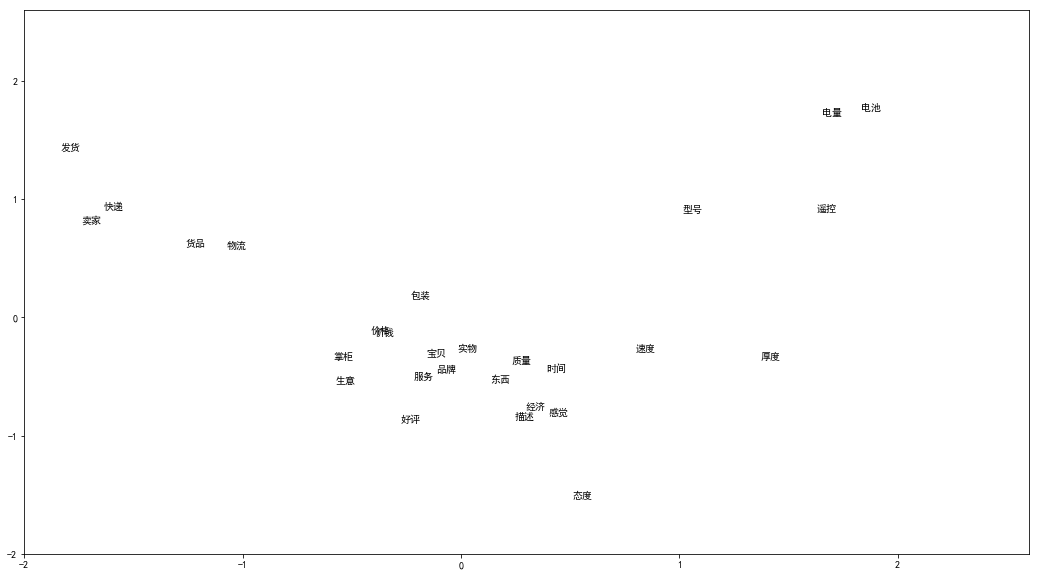

In [117]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置  
plt.rcParams['axes.unicode_minus'] = False 
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
for i in range(len(vector_reduced)):
    ax.text(vector_reduced[i][0],vector_reduced[i][1],new_words_list[i])
ax.axis([-2,2.6,-2,2.6])
plt.show()

## 选择适合的特征词做聚类标签的代表特征词

In [112]:
real_label = []
real_score = defaultdict(float)
label_to_fea = defaultdict(str)
for w in label_to_word_list_dict:  #w 是label
    len_list = []
    temp_score = []
    print(label_to_word_list_dict[w])
    for m in label_to_word_list_dict[w]:
        #print("特征词对应的观点词",fea_to_opinion_dict[m])
        a = len(fea_to_opinion_dict[m])
        len_list.append(a)
        print(final_dict[m])
        temp_score.append(final_dict[m])
        
        
    real_score[w] = sum(temp_score)/len(temp_score)
    print(len_list)
    b = len_list.index(max(len_list))
    real_label.append(label_to_word_list_dict[w][b])    
i = 0    
for w in label_to_word_list_dict:
    label_to_fea[w] = real_label[i]
    i += 1
print(real_label)
print(real_score)
print(label_to_fea)

['东西', '感觉', '货品', '宝贝', '电池']
-0.2724358974358974
1.525
1.5
1.3259803921568627
0.7652027027027026
[12, 7, 2, 12, 25]
['态度', '掌柜', '卖家']
2
2
1.0
[5, 2, 2]
['包装']
1.2336538461538462
[20]
['好评', '质量', '型号', '服务', '品牌']
1.0943396226415094
0.8833333333333333
0.375
1.1041666666666667
1.3421052631578947
[2, 20, 2, 3, 3]
['价格', '遥控', '价钱']
1.5693548387096774
-0.125
1.65625
[16, 2, 4]
['实物', '描述', '经济']
1.0
0.7
2
[2, 3, 2]
['快递', '发货', '时间', '物流', '速度']
1.15
0.7443181818181819
-0.25
0.8032894736842106
1.0729166666666665
[1, 12, 6, 19, 4]
['厚度']
0.0
[2]
['生意']
-1.0
[2]
['电量']
0.6375
[7]
['电池', '态度', '包装', '质量', '价格', '描述', '物流', '厚度', '生意', '电量']
defaultdict(<class 'float'>, {7: 0.9687494394847336, 2: 1.6666666666666667, 11: 1.2336538461538462, 0: 0.9597889771598809, 3: 1.033534946236559, 4: 1.2333333333333334, 9: 0.7041048644338118, 5: 0.0, 6: -1.0, 12: 0.6375})
defaultdict(<class 'str'>, {7: '电池', 2: '态度', 11: '包装', 0: '质量', 3: '价格', 4: '描述', 9: '物流', 5: '厚度', 6: '生意', 12: '电量'})


## 聚类标签特征词对应的分数

In [108]:
temp_final_dict = defaultdict(float)
for key in real_label:
    temp_final_dict[key] = real_score[word_to_lable_dict[key]]
print(temp_final_dict)
# if '赞' in temp_final_dict:
#     del temp_final_dict['赞']
real_final_dict = defaultdict(float)
for key in temp_final_dict:
    if temp_final_dict[key] > 0:
        real_final_dict[key] = temp_final_dict[key]
print(temp_final_dict)
print(real_final_dict)

defaultdict(<class 'float'>, {'电池': 0.9687494394847336, '态度': 1.6666666666666667, '包装': 1.2336538461538462, '质量': 0.9597889771598809, '价格': 1.033534946236559, '描述': 1.2333333333333334, '物流': 0.7041048644338118, '厚度': 0.0, '生意': -1.0, '电量': 0.6375})
defaultdict(<class 'float'>, {'电池': 0.9687494394847336, '态度': 1.6666666666666667, '包装': 1.2336538461538462, '质量': 0.9597889771598809, '价格': 1.033534946236559, '描述': 1.2333333333333334, '物流': 0.7041048644338118, '厚度': 0.0, '生意': -1.0, '电量': 0.6375})
defaultdict(<class 'float'>, {'电池': 0.9687494394847336, '态度': 1.6666666666666667, '包装': 1.2336538461538462, '质量': 0.9597889771598809, '价格': 1.033534946236559, '描述': 1.2333333333333334, '物流': 0.7041048644338118, '电量': 0.6375})


## 保存结果

In [109]:
with open('F:/data6/final_fea_to_score_dict.txt', 'w') as f:
    for key ,value in real_final_dict.items():
        f.write(key + ':')
        f.write(str(value))
        f.write('\n')

In [110]:
with open('F:/data6/final_fea_to_score_dict.pkl', 'wb+') as f:
    pickle.dump(real_final_dict, f)

## 每条评论对应的聚类标签特征

In [113]:
new_result_list = []
for w in results:
    #print(w)
    new_lable_list = []
    for n in w[0]:
        #print(n)
        new_lable_list.append(label_to_fea[word_to_lable_dict[n]])
    new_result_list.append((set(new_lable_list),w[1]))
print(new_result_list)

[({'包装', '电池', '态度'}, '\ufeff灰常好。南孚的质量一直不错终于收到我需要的宝贝了。东西很好。价美物廉。谢谢掌柜的。说实在。这是我淘宝购物来让我最满意的一次购物。无论是掌柜的态度还是对物品。我都非常满意的。掌柜态度很专业热情。有问必答。回复也很快。我问了不少问题。他都不觉得烦。都会认真回答我。这点我向掌柜表示由衷的敬意。这样的好掌柜可不多。再说宝贝。正是我需要的。收到的时候包装完整。打开后让我惊喜的是。宝贝比我想象中的还要好。不得不得竖起大拇指。下次需要的时候我还会再来的。到时候麻烦掌柜给个优惠哦。终于收到我需要的宝贝了。东西很好。价美物廉。谢谢掌柜的。说实在。这是我淘宝购物我最满意的一次购物。无论是掌柜的态度还是对物品。我都非常满意的。掌柜态度很专业热情。有问必答。回复也很快。我问了不少问'), (set(), '此用户没有填写评论。'), ({'质量'}, '看着不错。像正品。先好评吧。电池电量及耐用度有待验证。用后再来追评。'), ({'质量', '包装'}, '买了两板。邮寄的也很快。包装也不没有问题。什么都不说了。必须五星好评。质量上图'), (set(), '上在体重秤里的。五颗能用好久了。比超市零卖要便宜一半'), (set(), '此用户没有填写评论。'), ({'电池'}, '买来给我的三脚架蓝牙遥控器用的。也不知道经不经用。感觉三脚架自拍杆超级耗电。所以多买几个电池备用着。免得出门游玩时自拍杆没电了让人太扫兴。'), (set(), '此用户没有填写评论。'), ({'质量', '电池'}, '电池还未拆开使用。过后再评价。习惯性好评。'), (set(), '看着不错。放体重秤上用的。已经装上了非常好'), ({'质量', '价格', '电池'}, '宝贝收到了。正在使用中。质量应该不错吧。挺实惠的'), ({'电池'}, '装在车钥匙上刚好。就是不知道耐用不。'), ({'价格', '物流', '电池'}, '春节期间不发货。下单后才发现。只有耐心等待。电池收到后随即换到遥控钥匙里。感觉很好。但愿能用的时间长一点。'), ({'描述', '电池'}, '实物与图片一致。南孚电池不错。'), ({'电池'}, '电池挺不错。车子钥匙需要用。'), ({'价格'}, '电池不错价钱便宜'), ({'物流'}, '给力。好用

## 保存结果

In [114]:
with open('F:/data6/final_result.txt','w') as f:
    for w in new_result_list:
        f.write(str(w))
        f.write('\n')

In [115]:
with open('F:/data6/final_result.pkl', 'wb+') as f:
    pickle.dump(new_result_list, f)